# Data prep

* Representations of 1854 concepts with 49 features
* Generate correlation matrix

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns

data_dir = '../data'
output_dir = '../outputs'

In [2]:
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [35]:
temp = abs(np.corrcoef(original_embeddings, rowvar=False))
temp.min()

8.642178505132961e-05

In [42]:
(1-abs(temp.T + temp)/2)

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 1.11022302e-16, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        1.11022302e-16, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 0.00000000e+00, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [62]:
coef_embed = 1 - np.abs(np.corrcoef(original_embeddings, rowvar=False))
coef_embed

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 1.11022302e-16, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        1.11022302e-16, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 0.00000000e+00, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [59]:
eps = 1e-15
coef_embed[np.abs(coef_embed) < eps] = 0.00000000e+00
coef_embed

array([[0.        , 0.55704972, 0.52057449, ..., 0.88146932, 0.99551165,
        0.97168706],
       [0.55704972, 0.        , 0.92981187, ..., 0.93510138, 0.98569804,
        0.95550805],
       [0.52057449, 0.92981187, 0.        , ..., 0.93271344, 0.92507431,
        0.91670747],
       ...,
       [0.88146932, 0.93510138, 0.93271344, ..., 0.        , 0.96439405,
        0.99585957],
       [0.99551165, 0.98569804, 0.92507431, ..., 0.96439405, 0.        ,
        0.8939886 ],
       [0.97168706, 0.95550805, 0.91670747, ..., 0.99585957, 0.8939886 ,
        0.        ]])

In [63]:
real_coef = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
real_coef

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 0.00000000e+00, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        0.00000000e+00, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 2.22044605e-16, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [64]:
(coef_embed+coef_embed.T)/2 == real_coef

array([[ True,  True,  True, ...,  True, False,  True],
       [ True, False, False, ..., False,  True,  True],
       [ True, False,  True, ...,  True, False, False],
       ...,
       [ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False,  True]])

## Albatross (midway)
* Setup Albatross on midway: git install
* Send sbatch job
* Collect output: 
  1. euclidean vs. hyperbolic
  2. betticurve plot

In [1]:
### coef_embed.csv uploaded to midway
### submit albatross job: albatross all "/project/wilma/Membatross/mapping/work" "/project/wilma/Membatross/mapping/outputs/" --dataset_name="mbt_out" --log_dir="/project/wilma/Membatross/mapping" --input_data="/project/wilma/Membatross/mapping/data/coef_embed.csv" --distance_mode=distance --conda_env="/project/wilma/conda_envs/membatross" --n=49 --iters=150 --hyperbolic_dimensions=4 --min_eps=0.0 --partition=“caslake\n” --account="pi-wilma" --grid_threads=40 --grid_cpu=40 --grid_mem="80G" --max_eu_dim=60 --max_eps=0.3
### after albatross, run get_sub_stats.py to generate inference_stats.csv and betticurve plot
### run hyperbolic.sbatch to generate the loading of features/concepts in hyperbolic space 


## Visualize betti curves

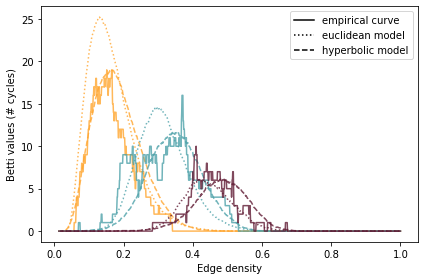

In [9]:
import numpy
import matplotlib.pyplot as plt
COLORS = ['#FFA630', '#4DA1A9', '#611C35']

emp_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/empirical_betti_curves_mbt_out_49.npz',allow_pickle=True)
eu_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/euclidean_model_dims_16_epsilon_0.08_mbt_out_49.npz',allow_pickle=True)
# emp_88 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/empirical_betti_curves_OPENFIELDm_88_n_75_i_150.npz',allow_pickle=True)
# eu_88 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/euclidean_model_dims_8_epsilon_0.14_OPENFIELDm_88_n_75_i_150.npz',allow_pickle=True)
hyp_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/hyperbolic_model_dims_3_rmax_21_rmin_0.40_epsilon_0.03_mbt_out_49.npz',allow_pickle=True)

emp_49 = [numpy.dstack([emp_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),emp_49.keys())]).mean(2).T for i in range(1,4)]
eu_49 = [numpy.dstack([eu_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),eu_49.keys())]).mean(2).T for i in range(1,4)]
# emp_88 = [numpy.dstack([emp_88.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),emp_88.keys())]).mean(2).T for i in range(1,4)]
# eu_88 = [numpy.dstack([eu_88.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),eu_88.keys())]).mean(2).T for i in range(1,4)]
hyp_49 = [numpy.dstack([hyp_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),hyp_49.keys())]).mean(2).T for i in range(1,4)]


plt.clf()
for i in range(1, 4):
    plt.plot(eu_49[i-1][0,:], eu_49[i-1][1,:], alpha=0.8, color=COLORS[i - 1],
                 linestyle=':')
    plt.plot(hyp_49[i-1][0, :], hyp_49[i-1][1, :], alpha=0.8, color=COLORS[i - 1],
             linestyle='--')
    plt.plot(emp_49[i - 1][0, :], emp_49[i - 1][1, :], alpha=0.8, color=COLORS[i - 1],
             linestyle='-')
#     plt.plot(emp_88[i - 1][0, :], emp_88[i - 1][1, :], alpha=0.8, color=COLORS[i - 1],
#              linestyle='--')
#     plt.text(0.35,25,'n=%d' % 75,size=15)
#     plt.text(0.62, 1, 'n=%d' % 30, size=15)
#     plt.arrow(0.18,10,-.08,20, length_includes_head=True, head_length=1,head_width=.025,color='black')
#     plt.arrow(0.4, 3.5, -.14, 23, length_includes_head=True, head_length=1, head_width=.025, color='black')
#     plt.arrow(0.52, 1, -.13, 14, length_includes_head=True, head_length=1, head_width=.025, color='black')
    plt.ylabel('Betti values (# cycles)')
    plt.xlabel('Edge density')
plt.plot([],[],linestyle='-',color='black',label='empirical curve')
plt.plot([], [], linestyle=':', color='black', label='euclidean model')
plt.plot([], [], linestyle='--', color='black', label='hyperbolic model')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('/Users/fiona/Desktop/membatross/albatross_49/outputs/sub_sample_hippo.png', dpi=300)

In [11]:
### stats from 3D, 4D, 5D and 6D
infer_stats = pd.read_csv('../albatross_49/inference_stats.csv')
infer_stats = pd.concat([infer_stats, pd.read_csv('../albatross_49_4D/inference_stats.csv')], ignore_index=True)
infer_stats = pd.concat([infer_stats, pd.read_csv('../albatross_49_5D/inference_stats.csv')], ignore_index=True)
infer_stats = pd.concat([infer_stats, pd.read_csv('../albatross_49_6D/inference_stats.csv')], ignore_index=True)
infer_stats = infer_stats.rename(columns={'Unnamed: 0': 'dim'})
infer_stats['dim'] = [3, 4, 5, 6]
infer_stats

,dim,hbp_p,hbp_chi,eu_p,eu_chi,sh_p,sh_chi
0,3,1.000000,-0.000000,0.405339,12.513888,1.447398e-12,82.381232
1,4,0.996704,2.816953,0.894859,6.395310,8.071210e-12,78.470885
2,5,0.294097,14.104308,0.775555,8.121627,7.965184e-12,78.501096
3,6,0.006157,27.681234,0.245262,14.930445,3.788303e-12,80.195151


In [20]:
pd.read_csv('../outputs/euclidean_reg_results')

,Unnamed: 0,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ_mem,cart_clust_typ,radius_clust_typ_mem,radius_clust_typ,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
0,rsquared,0.2958098464271871,1.2006956835008964e-05,"[0.23113606031599565, 0.327236259459858, 0.221...","[0.01504327574519937, 0.008388185044843843, 0....",0.4624624181766981,0.02000876517164807,0.321760450849203,0.03234558521826503,"[0.24427321421710346, 0.37929051875593256, 0.4...","[0.0718529136697812, 0.10027498441816296, 0.00...",0.31647724274982947,0.773336925326414,0.08343858036360818,0.030795448603241127,"[0.23812602837012342, 0.3684377681081653, 0.30...","[0.09841292560393866, 0.09679817019861547]"
1,rsquared_adj,0.2896764536905704,-0.000527943363382688,"[0.21767673533246823, 0.27421054591974836, 0.1...","[0.013983042457519246, 0.003839506994590791, 6...",0.45588200401512746,0.019267470742882264,0.31293191154172706,0.030880552039185938,"[0.225599732591654, 0.32316253374982007, 0.355...","[0.06921238141848618, 0.09141069855036166, -0....",0.30757993273968176,0.7705621669524451,0.08205090221124423,0.030062313541670216,"[0.21930065407112942, 0.3113284173519887]",[0.09584795526426293]
2,coef,[-0.34889794 1.24723816 0.17086315 0.303861...,[-0.02581978 0.02709856],"[array([-0.75884254, 1.41879146, 0.16109599,...","[array([-0.93401287, 1.00642244]), array([-0....",[-0.47879476 0.90204506 0.48910278 -0.503909...,[ 1.06076989 -1.1224051 ],[-0.26221883 1.21686052 0.07077614 0.309673...,[ 0.96757155 -0.13895715 -0.38924969],"[array([-1.0265177 , 1.33588982, -0.43236763,...","[array([-0.96685722, 1.35962531, 0.23913945]...",[-0.32349757 1.17912875 0.18854309 0.272630...,[ 0.07645919 1.61721732 -0.71243706 -0.235152...,[-0.33240214 1.66701922 -0.14110069],[ 1.3159952 -1.39246008],"[array([-1.1406699 , 1.21061455, -0.26365883,...","[array([-1.17980901, 3.39066295, 0.46917611])]"
3,pvalues,[1.32283503e-02 1.08521420e-29 1.32172075e-01 ...,[0.88147418 0.88242447],"[array([2.43203357e-03, 1.11559489e-12, 4.9426...","[array([0.00017577, 0.00019596]), array([0.175...",[2.26345483e-03 1.56187074e-14 7.98182265e-05 ...,[2.36429647e-07 2.92855808e-07],[1.37593379e-01 2.73232290e-19 6.12520908e-01 ...,[4.57511744e-11 4.98046247e-01 8.00054759e-02],"[array([8.88486516e-04, 1.68689997e-08, 1.5364...","[array([5.16497979e-04, 1.04750075e-09, 4.7856...",[6.71850636e-02 1.92042046e-14 1.89298890e-01 ...,[4.51975074e-001 9.82054920e-088 2.21084954e-0...,[9.78274596e-02 7.93753607e-27 5.03393565e-01],[1.28184462e-10 1.77521904e-10],"[array([2.42702091e-04, 8.86580704e-07, 3.8744...","[array([1.69585994e-05, 3.16257627e-14, 1.3053..."
4,AIC,4645.213572344282,5265.40182009131,"[2431.35833891299, 571.1335202778316, 1203.463...","[2631.951847859584, 626.4797705629284, 1285.68...",2969.4674952045693,3734.5890094588417,3279.299965313615,3719.8157651035312,"[1841.8080028975944, 522.3628967775257, 550.63...","[1956.8982761333214, 568.8354589594962, 634.97...",3289.5734213888472,1826.148459502615,3647.9941490808746,3719.935053448568,"[1847.527474138564, 525.933563724938]",[1936.4005601107494]
5,BIC,4739.14028502842,5276.452021583561,"[2513.5747466267, 628.8251885658218, 1273.3957...","[2641.6243664141384, 633.2670256556331, 1293.9...",3057.6705117250176,3744.9658349318356,3372.69139457056,3735.381003313022,"[1923.8810771724727, 582.2646678157381, 611.88...","[1970.577121845801, 578.819087465865, 645.1869...",3382.9648506457925,1914.3514760230632,3663.5593872903655,3730.311878921562,"[1929.6005484134423, 585.8353347631505]",[1950.079405823229]
6,F-statistic,48.22939914823688,0.02223715105888916,"[17.172931079298404, 6.171274983642228, 7.7418...","[14.18864689498275, 1.8440929325339528, 1.0284...",70.27861876497991,26.99165728921224,36.445491110487495,22.07839773198675,"[13.08128923768514, 6.75760084233608, 8.178466...","[27.21152662859553, 11.312246233213441, 0.5090..

In [21]:
pd.read_csv('../outputs/hbp3d_reg_results')

,Unnamed: 0,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ_mem,cart_clust_typ,radius_clust_typ,radius_clust_typ_mem,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
0,rsquared,0.09779136183152548,0.037210552135974795,"[0.018675313598234156, 0.31789396610134957, 0....","[0.007590616197680533, 0.0003197172753722777, ...",0.47894374086514724,0.38800560307718357,0.10692595768585444,0.045825470780563204,"[0.0567531071330053, 0.32617356761990346, 0.14...","[0.018361536456825145, 0.012934924069014198, 0...",0.12299168764891655,0.6710461025496975,0.4691343622381061,0.04992234289544861,"[0.10512452049093302, 0.3540932778911521, 0.21...","[0.06166268343476844, 0.07937119305187001]"
1,rsquared_adj,0.09632832079665765,0.03669068742330528,"[0.01426816680301668, 0.31446054646763144, 0.1...","[0.006109408162154661, -0.0013519888830302307,...",0.4777595220943862,0.3875426723684674,0.10421762093888198,0.04438084620945126,"[0.04603439244133478, 0.3199916737448567, 0.13...","[0.012815556436807096, 0.008427777603575937, 0...",0.12033207184193817,0.6702984800554923,0.4687327997284526,0.04848392100732657,"[0.09495548095105721, 0.3481675281470342]",[0.056361342663213354]
2,coef,[ 0.07846746 0.0202853 -0.00827201 1.30095944],[-0.04506921 1.05768304],"[array([ 0.0057021 , 0.05086068, 0.01082219,...","[array([ 0.03452844, -0.94862362]), array([ 0....",[ 0.09927589 -0.08975692 -0.04269879 2.71255612],[-0.14938597 3.3734176 ],[0.0737303 0.02167291 0.00703165 0.46499558 0...,[ 0.45474855 -0.03603413 0.56167235],"[array([ 0.05433983, 0.04854419, 0.03294991,...","[array([ 0.00180297, -0.80250788, 0.29001107]...",[0.06021724 0.04341003 0.01964479 1.02335672 0...,[ 0.08985752 -0.11981935 -0.06620882 2.79282842],[-0.16426288 3.70936637],[-0.02793104 0.52634688 0.4496188 ],"[array([ 0.04762256, 0.0376187 , 0.05536736,...","[array([-0.00523155, -4.2913707 , 0.71142488])]"
3,pvalues,[2.13732938e-42 1.03260358e-04 1.68984745e-01 ...,[5.33173903e-17 1.64265506e-16],"[array([7.41675364e-01, 6.22094097e-04, 4.6811...","[array([0.02390782, 0.02450123]), array([0.662...",[9.91077944e-074 2.16801298e-083 1.72185659e-0...,[3.85806172e-143 1.93651909e-139],[1.68792135e-21 8.95919831e-04 3.06443263e-01 ...,[1.31355486e-02 1.31844861e-05 3.28853266e-02],"[array([0.03210534, 0.01163142, 0.08480101, 0....","[array([0.93789026, 0.01779141, 0.67522339]), ...",[2.02688090e-14 2.79744357e-08 7.01287927e-03 ...,[4.69537296e-092 4.50963723e-190 1.60376362e-0...,[5.24872315e-184 1.58130779e-179],[0.0015907 0.00058199 0.06113261],"[array([4.31170239e-02, 4.51507090e-02, 3.2384...","[array([8.11269563e-01, 3.42146888e-06, 2.6483..."
4,AIC,5078.629906142558,5195.119412986571,"[1902.384912330042, 1481.1841448662426, 1121.1...","[1905.9330365496335, 1706.5343788081052, 1160....",2902.2372635877978,3111.222666854599,3617.623653385545,3701.242144146529,"[1002.2635972334851, 1087.4046067853244, 979.8...","[1012.5061166603804, 1251.7622711668578, 1007....",3593.589053485954,2293.276164333145,2922.9311003162443,3695.5451392139726,"[983.4698730127784, 1068.742607503825]",[996.4005685062494]
5,BIC,5100.730309127061,5206.169614478822,"[1920.4259456921345, 1498.771863487107, 1137.1...","[1914.9535532306797, 1715.3282381185375, 1168....",2922.9909145337856,3121.599492327593,3643.5657170680297,3716.80738235602,"[1021.6522761423834, 1107.8498311625585, 999.3...","[1024.1393240057193, 1264.0294057931983, 1019....",3619.531117168439,2314.029815279133,2933.307925789238,3711.1103774234634,"[1002.8585519216766, 1089.187831881059]",[1008.0337758515884]
6,F-statistic,66.84116132146777,71.57737624639825,"[4.237506592360376, 92.58814826462186, 16.6485...","[5.1246118138873005, 0.19125207726568974, 4.60...",404.43856548343484,838.1504958986221,39.48030384529745,31.721370172522324,"[5.2947679610418765, 52.76272517981983, 15.351...","[3.3107830159052383, 2.8698699206253444, 13.03...",

In [22]:
pd.read_csv('../outputs/hbp4d_reg_results')

,Unnamed: 0,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ,cart_clust_typ_mem,radius_clust_typ,radius_clust_typ_mem,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
0,rsquared,0.18015419331493665,0.019785249021574747,"[0.03813534302243793, 0.28394179391079455, 0.0...","[0.0016403876036032994, 0.00445234598418387, 0...",0.48928834540847443,0.32545039316408075,0.1838153767887719,0.033738863617616355,"[0.033072186922545654, 0.24463370497538128, 0....","[7.239272108217065e-05, 0.09948003350593215, 0...",0.422839607275025,0.1936318547067164,0.23516410697301493,0.10971204525209366,"[0.03682257250130283, 0.2533109956508123, 0.11...","[2.1181963797300973e-05, 0.06621357277818496]"
1,rsquared_adj,0.1783805950311398,0.01925597539793633,"[0.03276179745273078, 0.2732143301491585, 0.06...","[0.00025184850430370886, 0.0007651324507919055...",0.4877395610124424,0.3249401438396965,0.1807190770042072,0.03227593986836219,"[0.021309074841311282, 0.22555879853536565, 0....","[-0.004758175430023659, 0.09051963582937428, 0...",0.4210893104055027,0.19057279497495117,0.23458556242458306,0.10836414524490523,"[0.025105085548763895, 0.23445521271270142]",[-0.004809633582271378]
2,coef,[-0.02967984 0.00887881 0.02000017 -0.001046...,[-0.01549646 0.79280019],"[array([-0.01199222, 0.02789391, 0.00357435,...","[array([-0.00707581, 0.40707913]), array([ 0....",[-0.01436014 -0.04723449 0.05688089 -0.012962...,[-0.06137084 3.05154256],[-0.02729731 0.01387397 0.0152538 -0.003001...,[ 0.7996232 -0.00544761 -0.17232337],"[array([-0.00078005, 0.01910491, -0.00344861,...","[array([-0.00101754, -0.05016921, 0.080299 ]...",[-0.03224877 -0.00807543 0.05128426 0.019102...,[-0.02351934 0.01013133 0.01290366 -0.007545...,[-0.05216812 2.59395567],[ 0.00335531 2.0396676 -0.76460335],"[array([ 0.00323375, 0.02020606, -0.00263351,...","[array([-0.00080669, -0.02533705, 0.05094994])]"
3,pvalues,[8.19522640e-43 2.59633289e-03 3.03525750e-17 ...,[1.18150509e-09 2.09704423e-09],"[array([3.61440152e-02, 3.45437703e-06, 5.9469...","[array([0.27744016, 0.2798056 ]), array([0.272...",[5.09156211e-013 5.17083072e-058 4.90446306e-1...,[3.65179316e-115 5.49530674e-112],[6.62420194e-26 3.91685663e-04 7.26452944e-06 ...,[5.70014030e-06 1.24339360e-01 4.84661103e-01],"[array([0.91733646, 0.02242755, 0.71445491, 0....","[array([0.90981077, 0.87972838, 0.88674589]), ...",[2.06423920e-49 6.72974579e-03 4.43162604e-93 ...,[6.34408333e-18 4.14680376e-03 5.86141610e-05 ...,[4.93306340e-79 9.71937979e-77],[2.93583305e-01 7.80388654e-30 6.54151539e-05],"[array([0.69125142, 0.01305031, 0.7729221 , 0....","[array([0.92815852, 0.96692722, 0.92585491])]"
4,AIC,4903.147380622509,5228.374491038414,"[2028.0757836065595, 691.0562425051971, 1226.7...","[2048.925674297612, 774.6888199462076, 1245.29...",2877.687270728673,3240.0771165503797,3500.4253788532483,3717.9080283165877,"[1181.3704275885552, 533.6942139115256, 958.51...","[1189.364547835266, 563.5512013924235, 968.043...",3039.6323978050495,3484.4047284378616,3406.3927970227205,3609.4867670497106,"[1179.749880976153, 531.3371941787559]",[1189.3859037202433]
5,BIC,4930.772884353139,5239.424692530665,"[2050.978979292984, 709.0852528366771, 1247.17...","[2058.086952572182, 781.9004240787996, 1253.47...",2903.6293344111577,3250.4539420233737,3531.55585527223,3733.4732665260785,"[1205.568944919348, 553.6029338745909, 981.574...","[1201.4638065006625, 573.5055613739562, 979.57...",3065.5744614875343,3515.5352048568434,3416.7696224957144,3625.0520052592015,"[1203.9483983069458, 551.2459141418212]",[1201.4851623856398]
6,F-statistic,101.57553430265862,37.381891214533425,"[7.0968678924810815, 26.468678917959902, 8.943...","[1.1813766025247139, 1.2075096665443499, 10.28...",315.91766204648053,637.8262108565275,59.36614332536928,23.062626220140963,"[2.8115167732955535, 12.824896716776816, 6.709...","[0.014986378168710074, 11.10218955

In [23]:
pd.read_csv('../outputs/hbp5d_reg_results')

,Unnamed: 0,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem,cart_typ,radius_typ,cart_typ_mem,radius_typ_mem,cluster_cart_typ_mem,cluster_radius_typ_mem,cart_clust_typ,cart_clust_typ_mem,radius_clust_typ,radius_clust_typ_mem,cluster_cart_clust_typ_mem,cluster_radius_clust_typ_mem
0,rsquared,0.21579764684609437,0.0033304749345912654,"[0.34484395460100004, 0.1587160074968379, 0.04...","[0.0008028762786121968, 0.10821117326210827, 0...",0.36951291509507034,0.20311255383910043,0.2197324745879401,0.0355559031987388,"[0.3252253546029622, 0.1279873274227098, 0.046...","[0.07792725955175217, 0.09604810071864844, 0.0...",0.7003375426837675,0.2248597897164638,0.3814815464548653,0.06467061091723081,"[0.3256160096299874, 0.12962376601720116, 0.16...","[0.08423027251050563, 0.08430990227323065]"
1,rsquared_adj,0.2136758872325828,0.002792316443735343,"[0.3356937305032487, 0.14761727408650593, 0.03...","[-0.001957336770341822, 0.10588274290509037, 0...",0.36712108245127306,0.20250976454548397,0.21617772504164368,0.03409573045566339,"[0.3089001615691629, 0.11188863192897514, 0.03...","[0.07060922192914709, 0.0905529523947497, 0.00...",0.6992007351825678,0.22132839923681213,0.3810136807562684,0.0632545179738806,"[0.3093002679274871, 0.1135552816975186]",[0.07696225880027152]
2,coef,[-5.13288776e-02 -6.28157887e-04 1.90847874e-...,[ 0.01642684 -0.35976374],"[array([-0.06086187, 0.00210457, 0.04766362,...","[array([ 0.00821125, -0.1697274 ]), array([ 0....",[ 0.00321445 -0.01770659 0.0700509 0.046475...,[ 0.13431195 -3.00897007],[-0.05695865 -0.00608834 0.01783782 0.043374...,[ 0.79334366 0.01988228 -0.88513387],"[array([-0.06653772, -0.00458691, 0.04673199,...","[array([ 0.01052402, 1.68136951, -0.9917254 ]...",[ 0.00758476 -0.04988019 0.07479495 0.033926...,[-5.79371396e-02 3.62568818e-04 8.36723364e-...,[ 0.18407002 -4.1236923 ],[-0.01074216 1.22409062 -0.25776028],"[array([-0.05729839, -0.00459765, 0.04260165,...","[array([ 0.01085015, 2.38018857, -0.84252105])]"
3,pvalues,[1.85269111e-51 8.74054020e-01 1.76206951e-03 ...,[0.01294459 0.01412888],"[array([2.40828296e-08, 8.94164561e-01, 9.6178...","[array([0.58999207, 0.59507591]), array([3.624...",[3.84371923e-01 3.80482853e-05 7.80353496e-23 ...,[3.23223905e-67 6.24495237e-66],[7.88447089e-41 2.04734432e-01 2.72396537e-02 ...,[9.86699625e-07 2.76892850e-02 1.36633794e-06],"[array([1.10345593e-05, 8.17458904e-01, 9.8797...","[array([5.74491940e-01, 8.47929107e-06, 1.9866...",[2.95230779e-03 4.45421273e-58 4.97659690e-50 ...,[4.12837845e-42 9.44857450e-01 3.21213021e-01 ...,[4.30610271e-140 1.12206848e-137],[2.86913999e-01 9.99508899e-16 1.88521392e-01],"[array([2.82848306e-04, 8.16850900e-01, 2.0502...","[array([5.61254537e-01, 3.44405452e-06, 4.0891..."
4,AIC,4822.738579788398,5259.2390753642885,"[891.058264425743, 1038.0446637617338, 2536.03...","[1036.6948878256758, 1052.490193001918, 2537.5...",3158.637543356584,3460.7458502975987,3442.840425595323,3715.4159222463963,"[637.3476437907948, 910.7073470088999, 1531.71...","[708.9702050271653, 914.6501152978684, 1542.71...",2173.7987159359004,3434.1114091915206,3125.262230769954,3674.8311982252217,"[637.1999709641389, 910.0837230050163]",[707.2211164800127]
5,BIC,4855.889184265153,5270.28927685654,"[914.4411876315635, 1061.7641237674604, 2564.8...","[1044.4891955609492, 1060.3966796704935, 2547....",3189.768019775566,3471.1226757705927,3479.1593147508015,3730.981160455887,"[662.1364886069038, 937.3432917913153, 1561.80...","[719.5939956626406, 926.0655202046179, 1555.61...",2204.929192354882,3470.4302983469993,3135.639056242948,3690.3964364347125,"[661.9888157802478, 936.7196677874317]",[717.844907115488]
6,F-statistic,101.70692545558227,6.188650724981581,"[37.68694087893902, 14.30037118912029, 7.82849...","[0.2908747492938781, 46.47387152291453, 29.457...",154.48945228393993,336.95448142506547,61.81377104805416,24.350477275622104,"[19.921685086946482, 7.950167606594018, 4.3976...","[10.648655222957283, 17.478709410067864, 3.546.